# Android Data from PlayStore

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
%run ./Preprocessing.ipynb
df = get_data()
orig_df = df.copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
name               10841 non-null object
category           10841 non-null object
rating             9367 non-null float64
reviews            10841 non-null object
size               10841 non-null object
installs           10841 non-null object
type               10840 non-null object
price              10841 non-null object
content_rating     10840 non-null object
genres             10841 non-null object
last_updated       10841 non-null object
version            10833 non-null object
android_version    10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Number of duplicate entries : 1181
Original values : ['Free' 'Paid' nan]
Unique genres before preprocessing : 118
 Apps with more than one genre : 393 
Unique genres : 48
Oldest updated app : 2010
Longest app name with 25 words : 591 housing transactions - renting houses, middle-class houses, new cases, 

# Science

We transformed the problem in a classification one. Now rating can be *poor* (< 4) and *excellent* (>=4). 

We achieved the following : 
- 70% with RandomForest(n_estimators = 100)

Notes : 
- RandomForest clearly tends to overfit. Reducing the complexity of the tree algorithm doesn't improve accuracy in cross validation by no means. 
    + this may mean that the model is too complex. reducing the number of features took into account can help
**Next thing** : We should try adding or changing the features of data, and try more values for the hyperparameters of the algorithm

In [78]:
df = orig_df.copy()

In [79]:
df.columns.values

array(['category', 'rating', 'reviews', 'size', 'installs', 'type',
       'price', 'content_rating', 'genres', 'version', 'android_version',
       'price_rounded', 'last_updated_days', 'last_updated_year',
       'last_updated_day', 'last_updated_month_sin',
       'last_updated_month_cos', 'name_wc'], dtype=object)

In [80]:
pre_features = ['category', 'size', 'type', 'price', 'content_rating', 'genres', 'android_version', 'name_wc']
post_features = [feature for feature in df.columns.values if feature not in pre_features]

In [81]:
post_features

['rating',
 'reviews',
 'installs',
 'version',
 'price_rounded',
 'last_updated_days',
 'last_updated_year',
 'last_updated_day',
 'last_updated_month_sin',
 'last_updated_month_cos']

In [82]:
Y = df['rating'].values
df = df.drop(columns = ['rating'])[pre_features]
X = df.values

In [83]:
# split rating into two labels
Y = pd.cut(Y, 
           bins=[0, 4, 5], 
           labels=[0, 1])
Y.value_counts()
Y = Y.codes

0    2197
1    4913
dtype: int64

In [84]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [85]:
# the dataset is rather imbalanced, which will skew the results. So we reduce the number of big rating examples
# we can also try upsampling the small rating examples
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# from imblearn.usampler import TODO
sampler = RandomOverSampler(random_state = 42)
x_train, y_train = sampler.fit_resample(x_train,y_train)
len(y_train[y_train==1])
len(y_train[y_train==0])

3922

3922

In [9]:
from sklearn import preprocessing
# scale data if needed. forests and trees don't need it. Others do. 
scale = False
if scale:
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)

In [86]:
from sklearn import ensemble, tree, svm, neighbors
from sklearn.model_selection import cross_val_score
from model import Model, ModelsBenchmark

models = [
        svm.SVC(kernel = 'rbf', random_state=42),
        tree.DecisionTreeClassifier( min_impurity_decrease = 0, min_samples_leaf = 1, random_state = 42),
        ensemble.RandomForestClassifier(min_impurity_decrease=0, min_samples_leaf=1, random_state=42),
        neighbors.KNeighborsClassifier(n_neighbors = 2)
         ]
bench = ModelsBenchmark(models);
bench.fit(x_train, y_train);
bench.score(x_train, y_train);
bench.score(x_test, y_test);
bench._scores

/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[(0.9808771035186129,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best')),
 (0.9676185619581846,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.924655787863335, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter

[(0.6448663853727145, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)),
 (0.6315049226441631,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.6125175808720112,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_w

[(0.6448663853727145, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)),
 (0.6315049226441631,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.6125175808720112,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_w

In [61]:
from keras import layers

num_classes = 2
input_shape = x_train.shape[1]
model = keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

ModuleNotFoundError: No module named 'keras'

In [70]:
clf = ensemble.RandomForestClassifier(n_estimators = 100)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)
clf.score(x_test,y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

1.0

0.7144866385372715

In [67]:
# hyperparameters will be tuned agains the following score mean. 
# This is called cross-validation and is done to avoid overfitting the test data
scores = cross_val_score(clf, x_train, y_train, cv = 3)
scores
scores.mean()

array([0.61659021, 0.6185922 , 0.61820964])

0.617797350111179

In [220]:
# reduce dimensionality to be able to plot data
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 42);
    
def reduce_dimensions(X):
    pca.fit(X)
    return pca.transform(X)


/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[(0.8942014242115972, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)),
 (0.8031536113936928,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best')),
 (0.7115971515768057,
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=2, p=2,
             weights='uniform'))]

Text(0.5, 1.0, 'Train Data')

Text(0.5, 0, 'x_0')

Text(0, 0.5, 'x_1')

Text(0.5, 1.0, 'Test Data')

Text(0.5, 0, 'x_0')

Text(0, 0.5, 'x_1')

Text(0.5, 1.0, 'Test')

Text(0.5, 15.0, 'Predicted')

Text(455.608695652174, 0.5, 'Actual')

Text(0.5, 1.0, 'Train')

Text(0.5, 15.0, 'Predicted')

Text(666.913043478261, 0.5, 'Actual')

[[3960    0]
 [   1 3899]]
Train Accuracy : 1.00 
Test Accuracy : 0.89 


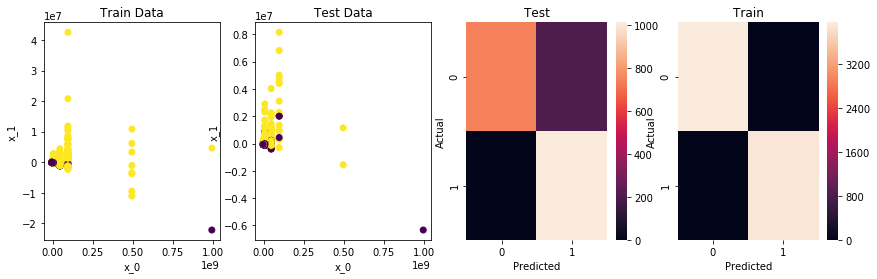

In [221]:
# print and plot metrics for the best one
from sklearn.metrics import confusion_matrix
bench.fit(x_train, y_train)
bench.score(x_test, y_test)
clf = bench._sorted[0]
fig, axs = plt.subplots(nrows = 1, ncols = 4);
fig.subplots_adjust(right = 2);
x_plot = reduce_dimensions(x_train)
axs[0].scatter(x_plot[:, 0], x_plot[:,1], c = y_train);
axs[0].set_title('Train Data');
axs[0].set_xlabel('x_0');
axs[0].set_ylabel('x_1');
x_plot = reduce_dimensions(x_test)
axs[1].scatter(x_plot[:, 0], x_plot[:,1], c = y_test);
axs[1].set_title('Test Data');
axs[1].set_xlabel('x_0');
axs[1].set_ylabel('x_1');
test_cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
sns.heatmap(test_cnf_matrix, ax = axs[2], vmin = 0);
axs[2].set_title('Test');
axs[2].set_xlabel('Predicted');
axs[2].set_ylabel('Actual');
train_cnf_matrix = confusion_matrix(y_train, clf.predict(x_train))
sns.heatmap(train_cnf_matrix, ax = axs[3], vmin = 0);
axs[3].set_title('Train');
axs[3].set_xlabel('Predicted');
axs[3].set_ylabel('Actual');
print(train_cnf_matrix)
print('Train Accuracy : %.2f ' % clf.score(x_train, y_train))
print('Test Accuracy : %.2f ' % clf.score(x_test, y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

Text(0.5, 1.0, 'Points with true label 0 ')

Text(0.5, 1.0, 'Points with true label 1 ')

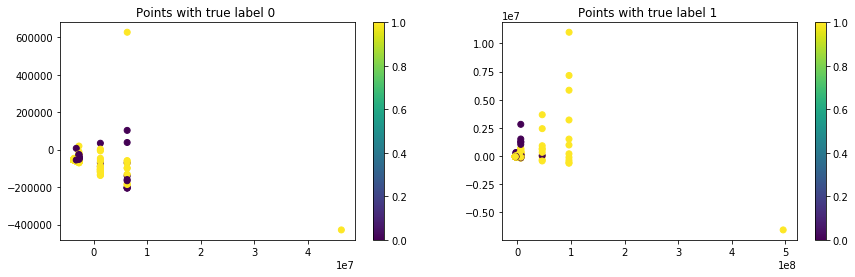

In [177]:
# plot both labels separately and our predictions on them
fig, axs = plt.subplots(nrows = 1, ncols = 2)
x_plot_train = reduce_dimensions(x_train)
y_plot_train = y_train
x_plot_test = reduce_dimensions(x_test)
y_plot_test = y_test
clf.fit(x_plot_train,y_plot_train)
x_plot = x_plot_test
y_plot = y_plot_test
y_pred = clf.predict(x_plot)
fig.subplots_adjust(right = 2)
labeled_0 = x_plot[y_plot == 0]
scatter = axs[0].scatter(labeled_0[:,0], labeled_0[:, 1], c = y_pred[y_plot ==  0])
fig.colorbar(scatter, ax = axs[0])
axs[0].set_title('Points with true label 0 ')
labeled_1 = x_plot[y_plot == 1]
scatter = axs[1].scatter(labeled_1[:,0], labeled_1[:, 1], c = y_pred[y_plot == 1] )
fig.colorbar(scatter, ax = axs[1])
axs[1].set_title('Points with true label 1 ')

In [296]:
# print some correctly and incorrectly labeled data
from random import randint
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
# correct = x_test[y_pred == y_test]
# incorrect = x_test[~(y_pred == y_test)]

columns = df.columns.values
def get_samples(x, y_true, y_pred, sample_type = 'correct', count = 5):
    mask = (y_pred == y_true)
    if sample_type == 'incorrect':
        mask = ~mask
    x = x[mask]
    y_pred = y_pred[mask]
    y_true = y_true[mask]
    df = pd.DataFrame(columns=[*columns , 'predicted', 'true'])
    if len(x) == 0:
        return df
    for _ in range(count):
        idx = randint(0, len(x)) 
        dct = {}
        dct['predicted'] = y_pred[idx]
        dct['true'] = y_true[idx]
        for i in range(x.shape[1]):
            dct[df.columns.values[i]] = x[idx][i]
        df = df.append(dct,
                       ignore_index=True)
    return df

print("====Correct samples =====")
get_samples(x_test, y_test, y_pred, sample_type='correct') 
print("====Incorrect samples =====")
get_samples(x_test, y_test, y_pred, sample_type='incorrect') 

AttributeError: 'Model' object has no attribute 'fit'

(0.6126602890291064, 0.5154711673699015)

2

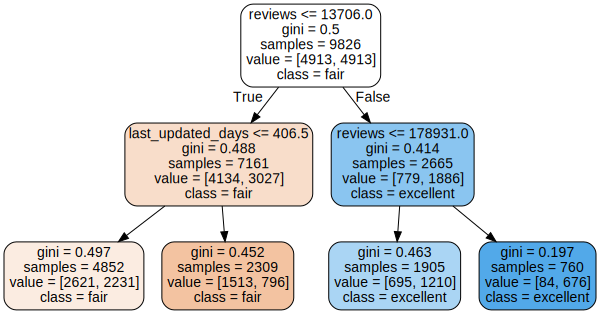

In [295]:
# Visualisation of the decision tree created by the algorithm, for fun and insight
import graphviz
from sklearn.tree import export_graphviz
clf = Model(tree.DecisionTreeClassifier(max_depth = 2))
clf.compute_scores((x_train, y_train), (x_test, y_test))
clf.model.tree_.max_depth
dot_data = export_graphviz(clf.model,
                           out_file=None,
                           feature_names=df.columns,
                           class_names=['fair', 'excellent'],
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph